**1. Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas**

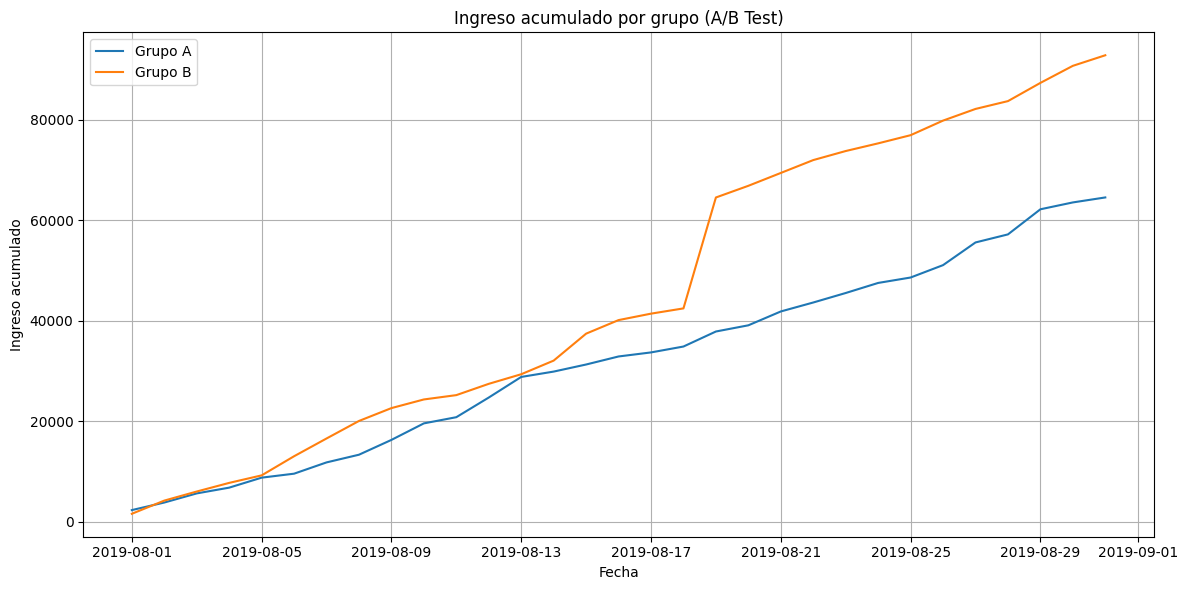

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date'])

# Agrupar por fecha y grupo, sumar ingresos diarios
daily_revenue = orders.groupby(['date', 'group'])['revenue'].sum().reset_index()

# Crear ingresos acumulados
cumulative_revenue = daily_revenue.copy()
cumulative_revenue['cumulative_revenue'] = (
    cumulative_revenue.groupby('group')['revenue'].cumsum()
)

# Pivotar para graficar
pivot_table = cumulative_revenue.pivot(index='date', columns='group', values='cumulative_revenue')

# Graficar
plt.figure(figsize=(12,6))
plt.plot(pivot_table['A'], label='Grupo A')
plt.plot(pivot_table['B'], label='Grupo B')
plt.title('Ingreso acumulado por grupo (A/B Test)')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusiones**
Grupo B parece ser más rentable que el grupo A durante el experimento.

La diferencia entre grupos es creciente y sostenida, lo que puede indicar un efecto positivo real de la variante B.

La variabilidad sugiere que eventos puntuales tales como promociones, campañas pudieron haber impactado los resultados a mitad del experimento, especialmente en el grupo B.

**Conjeturas**
Es probable que la variante B haya introducido un cambio funcional o visual que incentivó más compras o pedidos de mayor valor.

Podría ser útil:

Analizar estadísticamente la diferencia en ingresos (por ejemplo, con una prueba de hipótesis).

Verificar si usuarios duplicados o errores en la asignación de grupos afectan la validez del test.

Examinar si hay outliers (ej. pedidos anormalmente altos en grupo B).

**2. Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.**

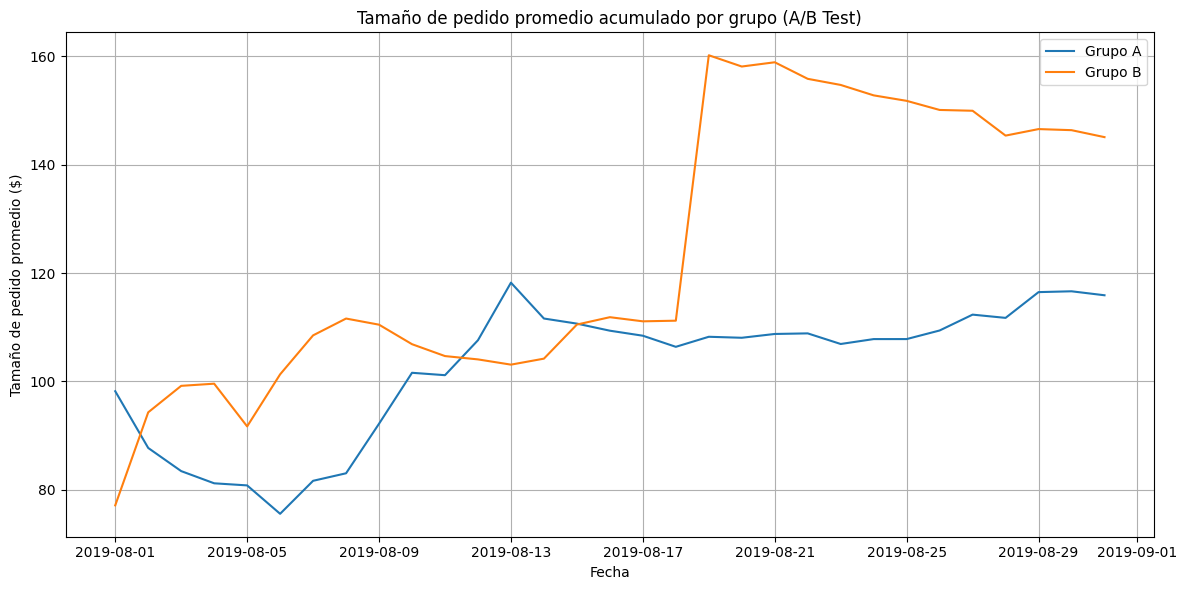

In [2]:
# Cargar datos
orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date'])

# Ordenar datos
orders = orders.sort_values(by=['group', 'date'])

# Calcular número acumulado de pedidos y revenue por grupo
orders['cum_orders'] = orders.groupby('group').cumcount() + 1
orders['cum_revenue'] = orders.groupby('group')['revenue'].cumsum()

# Calcular tamaño de pedido promedio acumulado
orders['avg_order_size'] = orders['cum_revenue'] / orders['cum_orders']

# Tomar solo un valor por día por grupo para graficar
daily_avg = orders.groupby(['date', 'group'])['avg_order_size'].last().unstack()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(daily_avg['A'], label='Grupo A')
plt.plot(daily_avg['B'], label='Grupo B')
plt.title('Tamaño de pedido promedio acumulado por grupo (A/B Test)')
plt.xlabel('Fecha')
plt.ylabel('Tamaño de pedido promedio ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Conclusiones preliminares**
El grupo B supera consistentemente al grupo A en tamaño de pedido promedio acumulado después del 18 de agosto.

El salto repentino sugiere la influencia de uno o varios pedidos atípicamente altos (outliers) en ese grupo.

La ventaja del grupo B en ingresos acumulados no solo se debe a más pedidos, sino también a pedidos de mayor valor.

**Conjeturas e hipótesis a validar**
El comportamiento del grupo B después del 18 de agosto puede estar influenciado por:

Outliers: un pedido o pocos pedidos de alto valor pueden distorsionar el promedio acumulado.

Cambio de comportamiento: la variante B podría haber incentivado compras más grandes a partir de cierto punto.

Error en los datos: convendría revisar si hubo errores de carga o asignación de grupo.

**3. Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.**

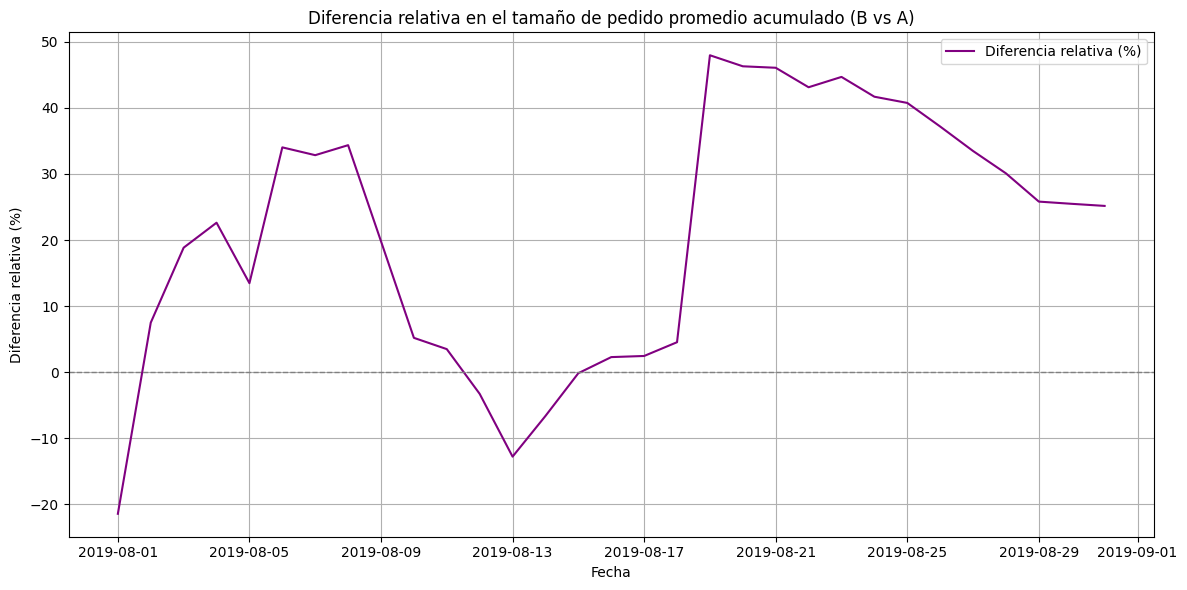

In [3]:
orders = orders.sort_values(by=['group', 'date'])

# Calcular ingresos y número acumulado de pedidos
orders['cum_orders'] = orders.groupby('group').cumcount() + 1
orders['cum_revenue'] = orders.groupby('group')['revenue'].cumsum()
orders['avg_order_size'] = orders['cum_revenue'] / orders['cum_orders']

# Último valor del día por grupo (para evitar duplicados)
daily_avg = orders.groupby(['date', 'group'])['avg_order_size'].last().unstack()

# Calcular diferencia relativa
relative_diff = ((daily_avg['B'] - daily_avg['A']) / daily_avg['A']) * 100

# Graficar
plt.figure(figsize=(12,6))
plt.plot(relative_diff, label='Diferencia relativa (%)', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title('Diferencia relativa en el tamaño de pedido promedio acumulado (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Conclusiones**
La variante B generó, en promedio, pedidos entre un 20% y 45% más grandes que la variante A durante la mayor parte del experimento.

El salto repentino el 18 de agosto indica la posible presencia de uno o varios pedidos muy grandes en el grupo B (outliers).

A pesar de ese posible outlier, la diferencia positiva se mantiene, lo que sugiere que la variante B podría tener un efecto real y sostenido sobre el tamaño del pedido.

**Conjeturas y recomendaciones**
Es recomendable examinar la distribución de los tamaños de pedido en ambos grupos (por ejemplo, con boxplots) para validar si el efecto es general o impulsado por valores extremos.

Se debe realizar una prueba de hipótesis para determinar si la diferencia observada es estadísticamente significativa.

También convendría revisar si hay segmentos de usuarios (por fecha, tipo de producto, etc.) que estén generando estos cambios.

**4. Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas.**

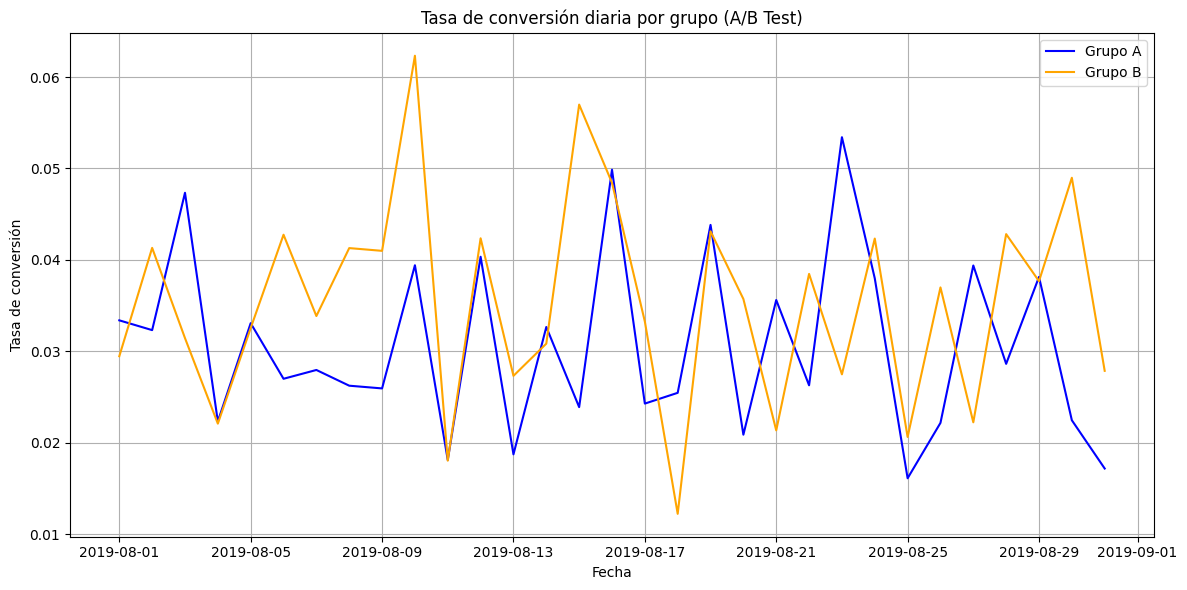

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos necesarios
orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date'])
visits = pd.read_csv('/datasets/visits_us.csv', parse_dates=['date'])

# Contar número de pedidos por día y grupo
daily_orders = orders.groupby(['date', 'group']).size().reset_index(name='orders')

# Unir con el dataset de visitas
merged = pd.merge(visits, daily_orders, how='left', on=['date', 'group'])

# Rellenar días sin pedidos con 0
merged['orders'] = merged['orders'].fillna(0)

# Calcular la tasa de conversión diaria
merged['conversion_rate'] = merged['orders'] / merged['visits']

# Separar las tasas por grupo para graficar
conv_A = merged[merged['group'] == 'A'][['date', 'conversion_rate']].set_index('date')
conv_B = merged[merged['group'] == 'B'][['date', 'conversion_rate']].set_index('date')

# Graficar
plt.figure(figsize=(12,6))
plt.plot(conv_A, label='Grupo A', color='blue')
plt.plot(conv_B, label='Grupo B', color='orange')
plt.title('Tasa de conversión diaria por grupo (A/B Test)')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusiones**
El grupo B generalmente presenta tasas de conversión más altas, aunque con más oscilaciones.

La mayor inestabilidad en B podría indicar:

Sensibilidad al volumen de tráfico (por ejemplo, pocos visitantes un día pueden causar fluctuaciones grandes).

Influencia de factores externos como campañas de marketing, errores o días no comparables.

A pesar de la variabilidad, los picos más altos y la mediana visualmente superior de B sugieren que la variante B podría convertir mejor que A.

**Conjeturas**
Puede valer la pena calcular la tasa de conversión acumulada para cada grupo, lo que suaviza el ruido y permite ver tendencias más claras.

Deberías aplicar una prueba de hipótesis de proporciones (por ejemplo, z-test o chi-cuadrado) para evaluar si la diferencia en tasas de conversión es estadísticamente significativa.

También podrías calcular una media móvil de 3 o 5 días para observar tendencias con menos ruido.

**5. Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.**

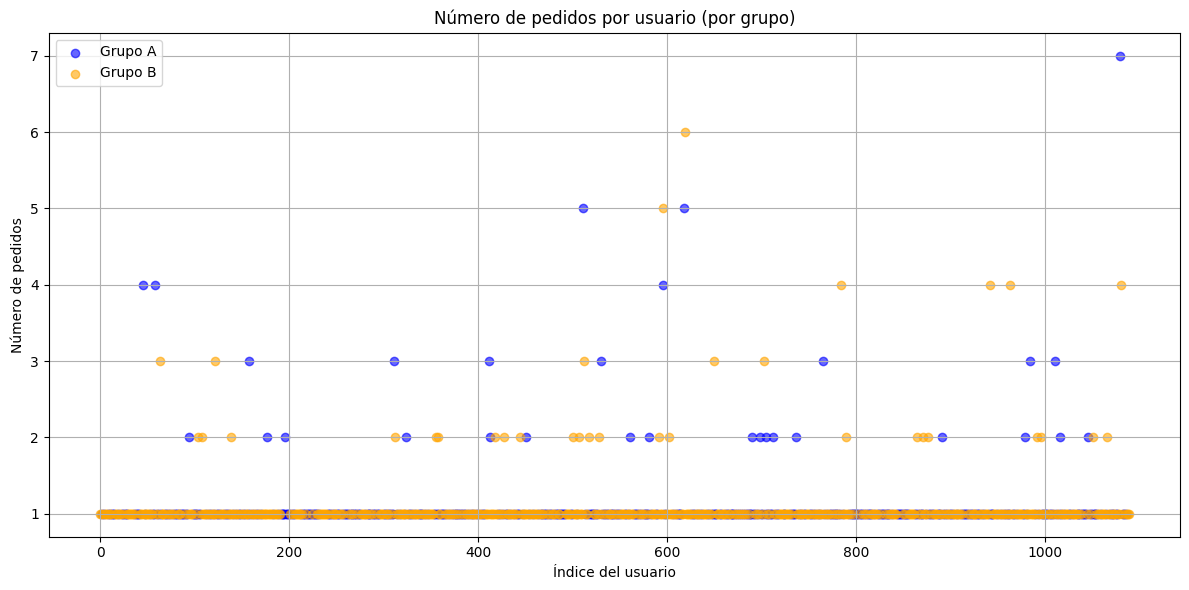

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
orders = pd.read_csv('/datasets/orders_us.csv')

# Contar pedidos por usuario y grupo
orders_per_user = orders.groupby(['visitorId', 'group']).size().reset_index(name='n_orders')

# Separar por grupo
group_A = orders_per_user[orders_per_user['group'] == 'A']
group_B = orders_per_user[orders_per_user['group'] == 'B']

# Graficar
plt.figure(figsize=(12,6))
plt.scatter(group_A.index, group_A['n_orders'], label='Grupo A', alpha=0.6, color='blue')
plt.scatter(group_B.index, group_B['n_orders'], label='Grupo B', alpha=0.6, color='orange')
plt.title('Número de pedidos por usuario (por grupo)')
plt.xlabel('Índice del usuario')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusiones**
El comportamiento general de los usuarios es de compra única, lo cual es común en tiendas online.

La presencia de clientes muy activos (más de 3 pedidos) podría tener un gran impacto en los ingresos, a pesar de ser pocos.

No hay una diferencia visual muy marcada entre los grupos A y B en cuanto al número de pedidos, pero el grupo B muestra una mayor concentración de puntos por encima de 2 pedidos, lo cual podría ser significativo.

**Conjeturas**
Los usuarios con más de 5 pedidos podrían ser:

Clientes fieles.

Empleados o testers del sistema (verifica si están presentes en ambos grupos).

Anomalías o duplicados a revisar.

Podrías complementar este análisis con:

Un histograma para ver la distribución de número de pedidos por grupo.

Cálculo de la media y mediana de pedidos por usuario en cada grupo.

Filtrado de outliers (por ejemplo, eliminar usuarios con más de 4 pedidos) para un análisis más representativo.

Realizar una prueba de hipótesis sobre el número medio de pedidos por grupo.

**6. Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.**

In [6]:
import pandas as pd

# Cargar pedidos
orders = pd.read_csv('/datasets/orders_us.csv')

# Calcular número de pedidos por usuario
orders_per_user = orders.groupby('visitorId').size()

# Calcular percentiles 95 y 99
p95 = orders_per_user.quantile(0.95)
p99 = orders_per_user.quantile(0.99)

print(f"Percentil 95: {p95}")
print(f"Percentil 99: {p99}")

# Definir umbral de anomalía (por ejemplo: pedidos > p99)
anomaly_threshold = p99
anomalous_users = orders_per_user[orders_per_user > anomaly_threshold]

print(f"Cantidad de usuarios anómalos: {len(anomalous_users)}")
print(f"Usuarios anómalos:\n{anomalous_users}")


Percentil 95: 2.0
Percentil 99: 4.0
Cantidad de usuarios anómalos: 10
Usuarios anómalos:
visitorId
199603092      5
237748145      5
1230306981     5
2038680547     8
2378935119     9
2458001652    11
3062433592     5
3717692402     5
3803269165     5
4256040402    11
dtype: int64


**7. Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.**

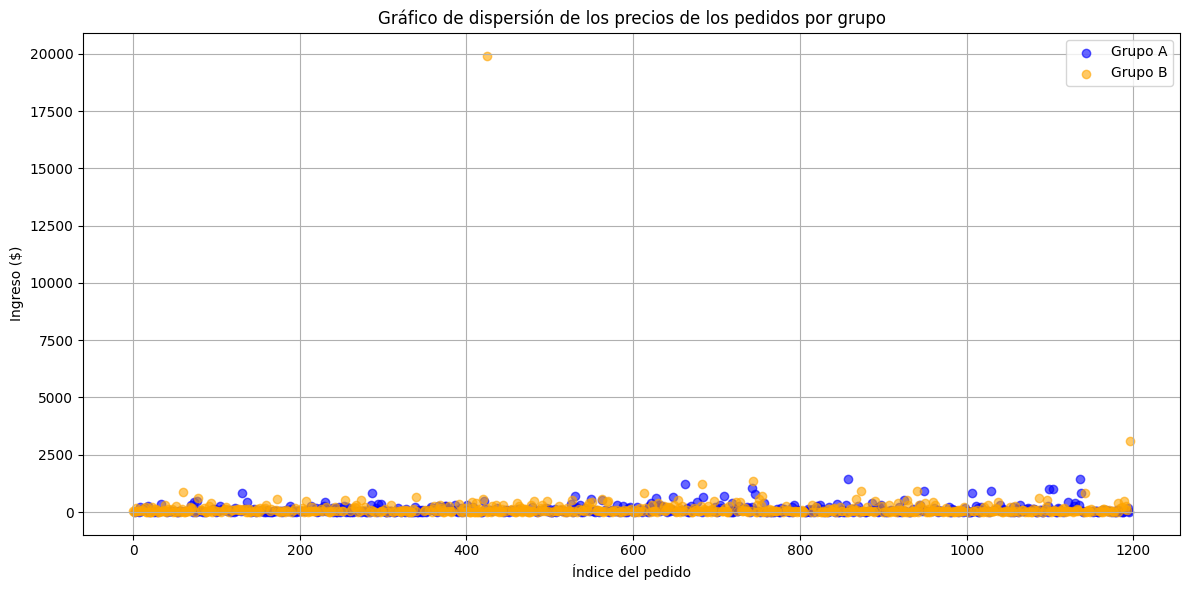

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
orders = pd.read_csv('/datasets/orders_us.csv')

# Separar por grupo
group_A = orders[orders['group'] == 'A']
group_B = orders[orders['group'] == 'B']

# Crear gráfico de dispersión
plt.figure(figsize=(12,6))
plt.scatter(group_A.index, group_A['revenue'], label='Grupo A', color='blue', alpha=0.6)
plt.scatter(group_B.index, group_B['revenue'], label='Grupo B', color='orange', alpha=0.6)
plt.title('Gráfico de dispersión de los precios de los pedidos por grupo')
plt.xlabel('Índice del pedido')
plt.ylabel('Ingreso ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusiones**

La mayoría de los pedidos en ambos grupos están concentrados en un rango bajo, probablemente por debajo de los $500.

Esto sugiere que los productos o tickets promedio de la tienda no son costosos.

Existen valores atípicos (outliers):

Un pedido supera los $19,000, lo cual es anómalo comparado con el resto.

Otro pedido supera los $2,500.

Estos outliers pueden distorsionar promedios y análisis estadísticos si no se manejan adecuadamente.

Ambos grupos (A y B) presentan outliers, aunque:

Visualmente parece que el grupo A tiene mayor dispersión, con varios pedidos por encima de $1000.

El grupo B es más compacto en su distribución.

La dispersión dentro del rango normal (0 a 500) parece similar en ambos grupos, lo que sugiere que sin los outliers podrían tener un comportamiento similar en ingresos por pedido.

**Conjeturas**

Los valores extremos pueden corresponder a errores, compras inusuales (ej. B2B), o comportamientos fraudulentos.

Sería útil revisar si estos usuarios son los mismos detectados como anómalos en el análisis anterior (usuarios con > 4 pedidos).

Es posible que el grupo A genere ingresos más altos debido a unos pocos pedidos muy caros, y no por un mejor desempeño general.

Para un análisis más justo entre los grupos, convendría:

Eliminar o analizar por separado los pedidos fuera del percentil 99.

Comparar métricas como mediana y percentiles, que no se ven afectadas por outliers.

**8. Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.**

In [8]:
import pandas as pd

# Cargar los datos
orders = pd.read_csv('/datasets/orders_us.csv')

# Calcular percentiles 95 y 99 del precio del pedido
p95 = orders['revenue'].quantile(0.95)
p99 = orders['revenue'].quantile(0.99)

print(f"Percentil 95: {p95:.2f}")
print(f"Percentil 99: {p99:.2f}")

# Definir umbral de anomalía (por ejemplo: revenue > p99)
anomaly_threshold = p99
anomalous_orders = orders[orders['revenue'] > anomaly_threshold]

print(f"\nCantidad de pedidos anómalos: {len(anomalous_orders)}")
print(f"Pedidos anómalos:\n{anomalous_orders[['transactionId', 'visitorId', 'revenue', 'group']]}")


Percentil 95: 435.54
Percentil 99: 900.90

Cantidad de pedidos anómalos: 12
Pedidos anómalos:
      transactionId   visitorId  revenue group
425       590470918  1920142716  19920.4     B
662      1811671147  4266935830   1220.2     A
682      1216533772  4266935830   1220.2     B
743      3603576309  4133034833   1050.0     A
744      3668308183   888512513   1335.6     B
858       192721366  1316129916   1450.2     A
940      2420050534  4003628586    905.8     B
949      1347999392   887908475    930.0     A
1099      316924019   148427295   1015.9     A
1103     1348774318  1164614297   1025.8     A
1136      666610489  1307669133   1425.8     A
1196     3936777065  2108080724   3120.1     B


 **Pedidos anómalos detectados (12 en total)**
 
Los valores van desde $905.8 hasta $19,920.4.

El pedido de $19,920.4 es extremadamente alto y probablemente distorsiona los promedios.

El grupo A tiene 8 de los 12 pedidos anómalos, y el grupo B tiene 4.

**Conclusiones**

Punto de corte para anomalía en precios de pedidos:

Todo pedido con revenue > $900.90 (percentil 99) es considerado una anomalía.

La existencia de estos valores extremos puede distorsionar los análisis:

El promedio del tamaño de pedido o ingreso por grupo puede parecer mayor solo por unos pocos pedidos.

Esto es especialmente importante en pruebas A/B, donde una diferencia puede ser significativa solo por un outlier.

El grupo A tiene el mayor número de pedidos anómalos, lo que podría explicar parte de sus ingresos más altos en algunas métricas (sin necesariamente significar que la variante A sea mejor).

**9. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.**

In [9]:
import pandas as pd
from scipy import stats as st

# Cargar datasets
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

# Contar pedidos por grupo
orders_by_group = orders.groupby('group').size()
conversions_A = orders_by_group['A']
conversions_B = orders_by_group['B']

# Sumar visitas por grupo
visits_by_group = visits.groupby('group')['visits'].sum()
visits_A = visits_by_group['A']
visits_B = visits_by_group['B']

# Proporciones de conversión
p1 = conversions_A / visits_A
p2 = conversions_B / visits_B

# Conversión combinada
p_combined = (conversions_A + conversions_B) / (visits_A + visits_B)

# Estadístico Z
difference = p1 - p2
z_value = difference / (
    (p_combined * (1 - p_combined) * (1/visits_A + 1/visits_B)) ** 0.5
)

# Valor p (bilateral)
p_value = 2 * (1 - st.norm.cdf(abs(z_value)))

print(f'Tasa de conversión A: {p1:.4f}')
print(f'Tasa de conversión B: {p2:.4f}')
print(f'Diferencia: {difference:.4f}')
print(f'Valor p: {p_value:.4f}')


Tasa de conversión A: 0.0297
Tasa de conversión B: 0.0338
Diferencia: -0.0041
Valor p: 0.0232


**Conclusiónes**

El valor p = 0.0232 es menor que 0.05 → hay una diferencia estadísticamente significativa en las tasas de conversión entre los grupos A y B.

El grupo B tiene una tasa de conversión mayor que el grupo A por 0.41 puntos porcentuales.

Esta diferencia no se debe al azar, según la prueba de hipótesis.

Aunque la diferencia es pequeña en magnitud, es consistente y significativa.

**Conjeturas**

Grupo B es mejor en conversión:

La variante aplicada al grupo B (por ejemplo, un nuevo diseño, mensaje o incentivo) incrementa la proporción de usuarios que hacen pedidos.

Esto puede traducirse en mayores ingresos a largo plazo si se mantiene el comportamiento.

Evalúa el impacto económico:

Una diferencia del 0.41% en conversión puede tener un gran efecto si la base de usuarios es alta.

Puedes calcular el ingreso adicional esperado si se implementa el cambio en toda la plataforma.

Valida otras métricas:

Asegúrate de que el tamaño de pedido promedio o el revenue total no se vean negativamente afectados.

Confirma que no hay efectos secundarios negativos (como más devoluciones, menor satisfacción, etc.).

**10. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.**

In [10]:
import pandas as pd
from scipy import stats as st

# Cargar datos
orders = pd.read_csv('/datasets/orders_us.csv')

# Separar por grupo
revenue_A = orders[orders['group'] == 'A']['revenue']
revenue_B = orders[orders['group'] == 'B']['revenue']

# Prueba de hipótesis (t-test para dos muestras independientes)
t_stat, p_value = st.ttest_ind(revenue_A, revenue_B, equal_var=False)  # Welch's t-test

# Calcular medias
mean_A = revenue_A.mean()
mean_B = revenue_B.mean()
diff = mean_B - mean_A

print(f'Tamaño de pedido promedio - Grupo A: {mean_A:.2f}')
print(f'Tamaño de pedido promedio - Grupo B: {mean_B:.2f}')
print(f'Diferencia: {diff:.2f}')
print(f'Valor p: {p_value:.4f}')


Tamaño de pedido promedio - Grupo A: 115.90
Tamaño de pedido promedio - Grupo B: 145.06
Diferencia: 29.17
Valor p: 0.3745


**Conclusión estadística**

El valor p = 0.3745 es mucho mayor que 0.05, por lo tanto:

No hay evidencia estadísticamente significativa de que los tamaños promedio de pedido sean diferentes entre los grupos A y B.

Aunque el grupo B tiene una media más alta (+$29.17):

Esta diferencia no es estadísticamente confiable.

Podría deberse simplemente al azar o a la influencia de outliers.

La gran dispersión de los datos (como vimos en los gráficos y outliers anteriores) puede estar afectando la varianza y reduciendo la potencia de la prueba.


**Conjeturas**

La variabilidad en el tamaño del pedido es alta:

Como vimos antes, hay valores anómalos (ej. pedidos de más de $9000 o $19000).

Estas anomalías inflan la media pero también aumentan la desviación estándar, lo que reduce la significancia estadística.

Deberías repetir esta prueba excluyendo outliers (por ejemplo, eliminando pedidos con revenue > p99 = $900.90).

Esto permitirá una comparación más representativa del comportamiento típico del usuario.

Es posible que la diferencia sea significativa una vez filtrados los extremos.

En contexto de negocio, aunque no sea estadísticamente significativo, una diferencia de ~$29 por pedido podría ser económicamente relevante si se replica a gran escala (dependiendo del costo de implementar el cambio del grupo B).

**11. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.**

In [11]:
import pandas as pd
from scipy import stats as st

# Cargar los datos
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

# 1. Contar número de pedidos por usuario
orders_per_user = orders.groupby('visitorId').size()

# 2. Filtrar usuarios con <= 4 pedidos
valid_users = orders_per_user[orders_per_user <= 4].index
filtered_orders = orders[orders['visitorId'].isin(valid_users)]

# 3. Recalcular pedidos por grupo
filtered_orders_by_group = filtered_orders.groupby('group').size()
conv_A = filtered_orders_by_group['A']
conv_B = filtered_orders_by_group['B']

# 4. Visitas por grupo (igual que antes, ya que los visitantes múltiples eran pocos)
visits_by_group = visits.groupby('group')['visits'].sum()
vis_A = visits_by_group['A']
vis_B = visits_by_group['B']

# 5. Tasa de conversión por grupo
p1 = conv_A / vis_A
p2 = conv_B / vis_B

# 6. Prueba estadística (Z para dos proporciones)
p_combined = (conv_A + conv_B) / (vis_A + vis_B)
diff = p2 - p1
z_value = diff / ((p_combined * (1 - p_combined) * (1/vis_A + 1/vis_B)) ** 0.5)
p_value = 2 * (1 - st.norm.cdf(abs(z_value)))

# Mostrar resultados
print(f"Tasa de conversión A (filtrada): {p1:.4f}")
print(f"Tasa de conversión B (filtrada): {p2:.4f}")
print(f"Diferencia: {diff:.4f}")
print(f"Valor p: {p_value:.4f}")


Tasa de conversión A (filtrada): 0.0279
Tasa de conversión B (filtrada): 0.0320
Diferencia: 0.0042
Valor p: 0.0175


**Conclusión**

El valor p = 0.0175 es menor que 0.05.

Por lo tanto, la diferencia entre los grupos A y B sigue siendo estadísticamente significativa incluso después de eliminar los usuarios con comportamiento extremo (más de 4 pedidos).

Grupo B sigue teniendo mejor rendimiento en conversión que el grupo A.

La diferencia (0.42%) es ligera en magnitud, pero estadísticamente confiable.

El filtrado de usuarios extremos refuerza la validez del resultado, descartando que la diferencia fuera causada por pocos usuarios hiperactivos.

**Conjeturas**

Grupo B es preferible desde el punto de vista de conversión:

Mejora constante, aunque modesta.

Recomendable si el costo de implementación del cambio es bajo o nulo.

Siguiente paso lógico:

Confirmar que no hay desventajas en ingresos promedio o ingresos totales.

Si todo se mantiene estable o mejora, implementar B como variante definitiva.

Impacto económico potencial:

Multiplica la diferencia de tasa por el volumen total de visitas para estimar cuántos pedidos adicionales generaría B.

Multiplica por el tamaño promedio de pedido para estimar el ingreso incremental esperado.

**12. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.**

In [12]:
import pandas as pd
from scipy import stats as st

# Cargar pedidos
orders = pd.read_csv('/datasets/orders_us.csv')

# Filtrar pedidos anómalos: revenue <= $900.90 (percentil 99 previamente calculado)
filtered_orders = orders[orders['revenue'] <= 900.90]

# Separar revenue por grupo
revenue_A = filtered_orders[filtered_orders['group'] == 'A']['revenue']
revenue_B = filtered_orders[filtered_orders['group'] == 'B']['revenue']

# Aplicar prueba t (Welch)
t_stat, p_value = st.ttest_ind(revenue_A, revenue_B, equal_var=False)

# Medias
mean_A = revenue_A.mean()
mean_B = revenue_B.mean()
diff = mean_B - mean_A

print(f"Tamaño promedio del pedido - Grupo A (filtrado): ${mean_A:.2f}")
print(f"Tamaño promedio del pedido - Grupo B (filtrado): ${mean_B:.2f}")
print(f"Diferencia: ${diff:.2f}")
print(f"Valor p: {p_value:.4f}")


Tamaño promedio del pedido - Grupo A (filtrado): $102.61
Tamaño promedio del pedido - Grupo B (filtrado): $104.47
Diferencia: $1.86
Valor p: 0.8174


**Conclusión estadística**

El valor p = 0.8174 es mucho mayor que 0.05.

Por lo tanto, no hay evidencia estadísticamente significativa de que los tamaños promedio de pedido difieran entre los grupos A y B después de filtrar los outliers.

Aunque el grupo B tiene un tamaño promedio de pedido ligeramente mayor ($1.86), la diferencia es muy pequeña y estadísticamente irrelevante.

Esto indica que el cambio aplicado al grupo B no afecta el tamaño del pedido, al menos entre los comportamientos típicos de los usuarios.

**Conjeturas**

El grupo B mejora la conversión sin afectar negativamente el tamaño del pedido.

Esto es positivo: más pedidos sin sacrificar el valor promedio por pedido.

Impacto potencial:

Aunque el tamaño del pedido no aumenta, el volumen de pedidos sí lo hace, lo que se traduce en mayores ingresos totales.

Implementación sugerida:

Si no hay otros efectos negativos (costos, quejas, retornos, etc.), puedes recomendar la implementación del cambio del grupo B a todos los usuarios.



**Decisión: 1. Parar la prueba, considerar al grupo B como líder.**

Resumen de resultados clave


Tasa de conversión (sin filtrar), B: 3.38% > A: 2.97%, p = 0.0232

Tasa de conversión (filtrada), B: 3.20% > A: 2.79%,  p = 0.0175

Tamaño promedio del pedido (bruto), B: 145.06 > A: 115.90, p = 0.3745

Tamaño promedio (filtrado), B: 104.47 ≈ A: 102.61, p = 0.8174


El grupo B muestra una mejora consistente y significativa en la conversión, incluso al excluir outliers.

No hay diferencia significativa en el tamaño promedio de pedido entre los grupos, lo cual no es negativo: significa que la mejora en conversión no compromete el valor por pedido.

Dado que la conversión es una métrica crítica en comercio electrónico, una mejora real (aunque pequeña) justifica tomar decisiones.

**Recomendación**

Implementa la variante del grupo B en todo el sitio:

Mejora la conversión.

No reduce el ingreso por pedido.

Puede generar mayores ingresos globales con un cambio moderado.

